<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

______________________________________________________________________

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
#%pip install anomalib

### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.

In [3]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)

## Imports

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above list. Let's take a quick look at its config file.

In [33]:
MODEL = "stfpm"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  category: carpet
  task: segmentation
  train_batch_size: 32
  eval_batch_size: 32
  inference_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_t

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/main/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [34]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.

In [35]:
##datamodule??
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


Let's check the shapes of the input images and masks.

In [36]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


We could now visualize a normal and abnormal sample from the validation set.

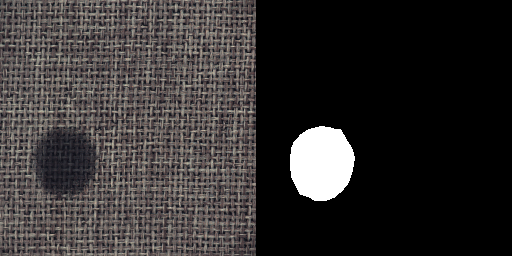

In [37]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [38]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [39]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
#trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


## Validation

In [40]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

Missing logger folder: results\stfpm\mvtec\carpet\run\lightning_logs


FileNotFoundError: [Errno 2] No such file or directory: ''

## OpenVINO Inference
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.

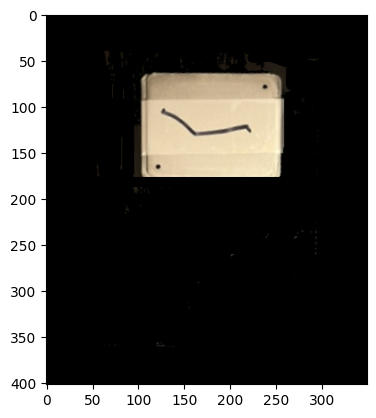

In [13]:
# orig image_path = root_directory / "datasets/MVTec/bottle/test/broken_large/000.png"
#orig image = read_image(path="./datasets/MVTec/bottle/test/broken_large/000.png")
image_path = root_directory / "datasets/MVTec/IHT/test/crack/002.png"
image = read_image(path="./datasets/MVTec/IHT/test/crack/002.png")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [23]:
output_path = Path(config["project"]["path"])
print(output_path)

results\stfpm\mvtec\iht-old\run


In [24]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata_path = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

False False


In [16]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata_path=metadata_path,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

In [17]:
print(image.shape)

(402, 349, 3)


In [18]:
predictions = inferencer.predict(image=image)

where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

In [19]:
print(predictions.pred_score, predictions.pred_label)

0.6768733766054232 True


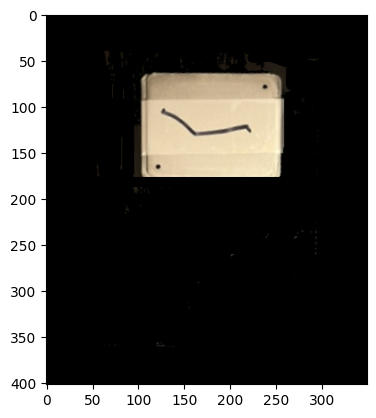

In [20]:
# Visualize the original image
plt.imshow(predictions.image)

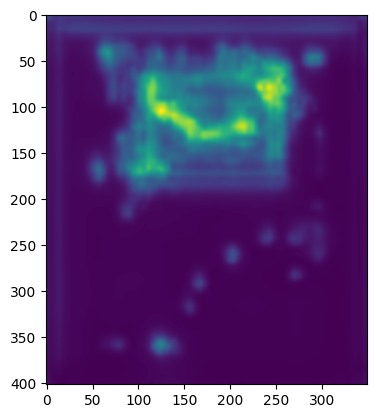

In [21]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

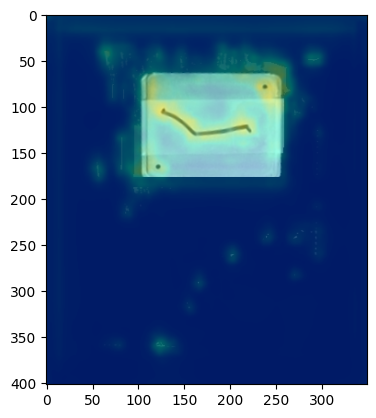

In [22]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

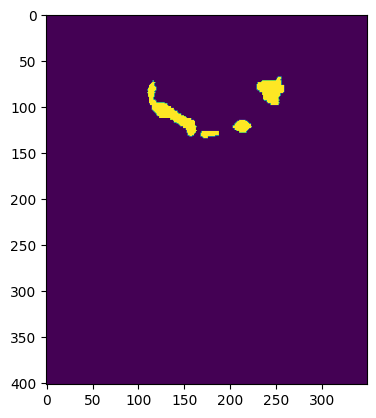

In [23]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

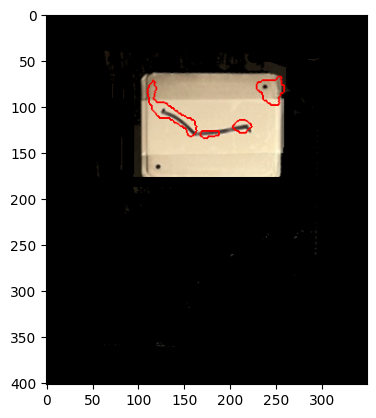

In [24]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.